In [194]:
# A script to export the reactions from an RMG mechanism and the database
# produces 3 files:

# make a dict entry for index

# species_dict_file = 'species_dict.pickle'
# reaction_dict_file = 'reaction_dict.pickle'

# correlated_uncertainty_file = 'correlated_uncertainty.pickle'


In [2]:
# example script to show how to unpack information in pickled files
import pickle
import numpy as np

In [195]:
import os
import copy
import itertools
import numpy as np
import scipy.stats
import rmgpy.data.thermo
import rmgpy.data.rmg
import rmgpy.chemkin
import rmgpy.exceptions

import rmgpy.tools.uncertainty
import matplotlib.pyplot as plt
%matplotlib inline


import importlib
importlib.reload(rmgpy.tools.uncertainty)

<module 'rmgpy.tools.uncertainty' from '/home/moon/rmg/RMG-Py/rmgpy/tools/uncertainty.py'>

In [4]:
# load example 

gas_chemkin = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20241020/chem_annotated-gas.inp'
gas_surface = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20241020/chem_annotated-surface.inp'
sp_dict = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20241020/species_dictionary.txt'
test_species_list, test_reaction_list = rmgpy.chemkin.load_chemkin_file(gas_chemkin, sp_dict, surface_path=gas_surface)

In [5]:
type(test_reaction_list[-1])

rmgpy.data.kinetics.family.TemplateReaction

In [113]:
# Load the database
database = rmgpy.data.rmg.RMGDatabase()
database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = ['surfaceThermoPt111', 'primaryThermoLibrary'],
    reaction_libraries = ['Surface/CPOX_Pt/Deutschmann2006_adjusted'],
#     kinetics_families = ['Surface_Abstraction'],
    kinetics_families = ['surface'],
    kinetics_depositories = ['training'],
    depository = True,
)

In [114]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    return -1

In [115]:
# Collect all of the training reactions

reaction_list = []
species_list = []  # build this up as you go to make sure all reactions use the same species object
for family in database.kinetics.families.keys():
#     print(family)
    training_depository = database.kinetics.families[family].get_training_depository()
    for i, entry in enumerate(training_depository.entries):
#         print(f'Reaction {i + 1}:')
#         display(training_depository.entries[entry].item)
        
        my_reaction = rmgpy.data.kinetics.family.TemplateReaction()
        my_reaction.reactants = training_depository.entries[entry].item.reactants
        my_reaction.products = training_depository.entries[entry].item.products
        my_reaction.family = family
#         my_reaction = training_depository.entries[entry].item
        
        
#         for j in range(len(my_reaction.reactants)):
#             i_thing = get_i_thing(my_reaction.reactants[j], species_list)
#             if i_thing < 0:
#                 my_reaction.reactants[j].thermo = database.thermo.get_thermo_data(my_reaction.reactants[j])
#                 species_list.append(my_reaction.reactants[j])
#             else:
#                 my_reaction.reactants[j] = species_list[i_thing]  # reuse species objects
            
# #             my_reaction.reactants[j].thermo = database.thermo.get_thermo_data(my_reaction.reactants[j])
#         for j in range(len(my_reaction.products)):
#             i_thing = get_i_thing(my_reaction.products[j], species_list)
#             if i_thing < 0:
#                 my_reaction.products[j].thermo = database.thermo.get_thermo_data(my_reaction.products[j])
#                 species_list.append(my_reaction.products[j])
#             else:
#                 my_reaction.products[j] = species_list[i_thing]  # reuse species objects
        
        
#             my_reaction.products[j].thermo = database.thermo.get_thermo_data(my_reaction.products[j])
        
        
        
#         my_reactions.append(training_depository.entries[entry].item)
        
        try:
            template_labels = database.kinetics.families[family].get_reaction_template_labels(my_reaction)
            template = database.kinetics.families[family].retrieve_template(template_labels)
            kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=my_reaction.degeneracy)[0]
            my_reaction.kinetics = kinetics
        except:
            continue
        reaction_list.append(my_reaction)
print(len(reaction_list))


44


In [116]:
species_list = []


for i in range(len(reaction_list)):
     for j in range(len(reaction_list[i].reactants)):
        i_thing = get_i_thing(reaction_list[i].reactants[j], species_list)
        if i_thing < 0:
            reaction_list[i].reactants[j].thermo = database.thermo.get_thermo_data(reaction_list[i].reactants[j])
            species_list.append(reaction_list[i].reactants[j])
        else:
            reaction_list[i].reactants[j] = species_list[i_thing]  # reuse species objects

for i in range(len(reaction_list)):
    for j in range(len(reaction_list[i].products)):
        i_thing = get_i_thing(reaction_list[i].products[j], species_list)
        if i_thing < 0:
            reaction_list[i].products[j].thermo = database.thermo.get_thermo_data(reaction_list[i].products[j])
            species_list.append(reaction_list[i].products[j])
        else:
            reaction_list[i].products[j] = species_list[i_thing]  # reuse species objects
        

In [12]:
len(species_list)

48

In [13]:
species_list[9].thermo

NASA(polynomials=[NASAPolynomial(coeffs=[0,0,0,0,0,0,0], Tmin=(298,'K'), Tmax=(1000,'K')), NASAPolynomial(coeffs=[0,0,0,0,0,0,0], Tmin=(1000,'K'), Tmax=(3000,'K'))], Tmin=(298,'K'), Tmax=(3000,'K'), Cp0=(0.01,'J/(mol*K)'), CpInf=(24.9434,'J/(mol*K)'), label="""vacant""", comment="""Thermo library: surfaceThermoPt111""")

In [14]:
len(species_list)

48

In [15]:
len(include_species_list)

NameError: name 'include_species_list' is not defined

In [ ]:
# for i in range(len(reaction_list)):
#     print(reaction_list[i].is_surface_reaction(), reaction_list[i])

In [117]:
# Trim the set to just surface reactions and the species reacting in them
# Per Joy's request, make sure to only include species involved in reactions
surface_only = True

reacting_species_set = set()
for i in range(len(reaction_list)):
    if surface_only and not reaction_list[i].is_surface_reaction():
        continue
    for sp in reaction_list[i].reactants + reaction_list[i].products:
        reacting_species_set.add(species_list.index(sp))
include_species_list = [species_list[i] for i in reacting_species_set]



include_reactions_set = set()
for i in range(len(reaction_list)):
    if surface_only and not reaction_list[i].is_surface_reaction():
        continue
    include_reactions_set.add(i)
include_reactions_list = [reaction_list[i] for i in include_reactions_set]



# Fill out the species dictionary

In [118]:
species_dict = {}
for i in range(len(include_species_list)):
    print(i, include_species_list[i])
    species_label = include_species_list[i].to_chemkin()
    
    if type(include_species_list[i].thermo) == rmgpy.thermo.thermodata.ThermoData:
        include_species_list[i].thermo = include_species_list[i].thermo.to_nasa(
            np.min(include_species_list[i].thermo.Tdata.value_si),
            np.max(include_species_list[i].thermo.Tdata.value_si),
            np.mean(include_species_list[i].thermo.Tdata.value_si)
        )
    
    species_entry = {
        'index': i,
        'RMG_adjacency_list': include_species_list[i].to_adjacency_list(),
        'NASA0': {
            'coeffs': include_species_list[i].thermo.polynomials[0].coeffs,
            'Tmin': include_species_list[i].thermo.polynomials[0].Tmin.value_si,
            'Tmax': include_species_list[i].thermo.polynomials[0].Tmax.value_si
        },
        'NASA1': {
            'coeffs': include_species_list[i].thermo.polynomials[1].coeffs,
            'Tmin': include_species_list[i].thermo.polynomials[1].Tmin.value_si,
            'Tmax': include_species_list[i].thermo.polynomials[1].Tmax.value_si
        },
        'comment': include_species_list[i].thermo.comment
    }
    
    species_dict[species_label] = species_entry



0 CH2X_1
1 HOX_3
2 CHX_1
3 CX_1
4 OX_1
5 HCOX_3
6 H2O*
7 CH4*
8 HCCH
9 X_3
10 H2CCH2
11 H2CO
12 H2
13 NO
14 H2O
15 CO2
16 CH4
17 CC_2X
18 CCH_2X
19 HCCH_2X
20 HCCH2_2X
21 HOCXO_1
22 NH2_X
23 NHX_2
24 HCOO*
25 CH3O2*
26 H2CCH2_2X
27 H2CO_2X
28 HCOOH*
29 H2CCH3_X
30 HCCH3_X
31 NH3_X
32 XCCH2
33 XCHCH2
34 HCCHX_vdW
35 H2CCH2X_vdW
36 H2COX_vdW
37 CH3X_4
38 COX_5
39 HCCH_2X
40 HX_3
41 NO_X
42 CO2X
43 NX
44 CH2OH*_2
45 HCO_2X
46 XCXCH2_3
47 HCOH*


In [119]:
species_dict_file = 'species_dict.pickle'
with open(species_dict_file, 'wb') as f:
    pickle.dump(species_dict, f)

In [120]:
# read back in to check
with open(species_dict_file, 'rb') as f:
    my_data = pickle.load(f)


# Fill out the reaction dictionary

In [121]:
reaction_dict = {}
N = len(species_dict)
for i in range(len(include_reactions_list)):
    reaction_label = str(include_reactions_list[i])
    
    
    if type(include_reactions_list[i].kinetics) in [rmgpy.kinetics.surface.SurfaceArrheniusBEP, rmgpy.kinetics.surface.StickingCoefficientBEP]:
        kinetic_entry = {
            'A': include_reactions_list[i].kinetics.A.value,
            'n': include_reactions_list[i].kinetics.n.value,
            'alpha': include_reactions_list[i].kinetics.alpha.value,
            'E0': include_reactions_list[i].kinetics.E0.value,
            'A_units': include_reactions_list[i].kinetics.A.units,
            'E0_units': include_reactions_list[i].kinetics.E0.units
        }
    elif type(include_reactions_list[i].kinetics) in [rmgpy.kinetics.surface.SurfaceArrhenius, rmgpy.kinetics.surface.StickingCoefficient]:
        kinetic_entry = {
            'A': include_reactions_list[i].kinetics.A.value,
            'n': include_reactions_list[i].kinetics.n.value,
            'Ea': include_reactions_list[i].kinetics.Ea.value,
            'A_units': include_reactions_list[i].kinetics.A.units,
            'Ea_units': include_reactions_list[i].kinetics.Ea.units
        }
    
    reaction_entry = {
        'index': N + i,
        'parameterization': str(type(include_reactions_list[i].kinetics)),
        'kinetics': kinetic_entry,
        'comment': include_reactions_list[i].kinetics.comment,
        'reactants': [str(include_reactions_list[i].reactants[j].to_chemkin()) for j in range(len(include_reactions_list[i].reactants))],
        'products': [str(include_reactions_list[i].products[j].to_chemkin()) for j in range(len(include_reactions_list[i].products))],
    }
    
    reaction_dict[reaction_label] = reaction_entry


In [122]:
reaction_dict_file = 'reaction_dict.pickle'
with open(reaction_dict_file, 'wb') as f:
    pickle.dump(reaction_dict, f)

In [123]:
# read back in to check
with open(reaction_dict_file, 'rb') as f:
    my_data = pickle.load(f)


In [124]:
my_data

{'CH2X_1 + HOX_3 <=> CH3X_4 + OX_1': {'index': 47,
  'parameterization': "<class 'rmgpy.kinetics.surface.SurfaceArrheniusBEP'>",
  'kinetics': {'A': 4.18e+17,
   'n': 0.0,
   'alpha': 0.37,
   'E0': 99.3,
   'A_units': 'm^2/(mol*s)',
   'E0_units': 'kJ/mol'},
  'comment': 'Estimated using template [Abstracting;*R-H] for rate rule [C=*;*OH]\nEuclidian distance = 2.23606797749979\nfamily: Surface_Abstraction',
  'reactants': ['CH2X_1', 'HOX_3'],
  'products': ['CH3X_4', 'OX_1']},
 'CHX_1 + HOX_3 <=> CH2X_1 + OX_1': {'index': 48,
  'parameterization': "<class 'rmgpy.kinetics.surface.SurfaceArrheniusBEP'>",
  'kinetics': {'A': 4.18e+17,
   'n': 0.0,
   'alpha': 0.37,
   'E0': 99.3,
   'A_units': 'm^2/(mol*s)',
   'E0_units': 'kJ/mol'},
  'comment': 'Estimated using template [Abstracting;*R-H] for rate rule [C#*;*OH]\nEuclidian distance = 2.23606797749979\nfamily: Surface_Abstraction',
  'reactants': ['CHX_1', 'HOX_3'],
  'products': ['CH2X_1', 'OX_1']},
 'CX_1 + HOX_3 <=> CHX_1 + OX_1': {'

In [ ]:
rmgpy.chemkin.save_species_dictionary('species_dictionary.txt', species_list)

In [ ]:
rmgpy.chemkin.save_chemkin_file('my_reactions.inp', species_list, reaction_list)

# Run uncertainty Analysis

In [196]:
uncertainty = rmgpy.tools.uncertainty.Uncertainty(species_list=species_list, reaction_list=reaction_list)

In [197]:
# uncertainty = rmgpy.tools.uncertainty.Uncertainty()
# uncertainty.load_model('my_reactions.inp', 'species_dictionary.txt', transport_path=None, surface_path=None)

In [198]:
len(uncertainty.species_list)

48

In [199]:
len(uncertainty.reaction_list)

44

In [200]:
uncertainty.database = database

In [201]:
uncertainty.extract_sources_from_model()

In [202]:
uncertainty.assign_parameter_uncertainties(correlated=True)

In [203]:
uncertainty.get_thermo_covariance_matrix()

array([[47.858724,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 47.858724,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 47.858724, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 47.858724,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      , 47.858724,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
        47.858724]])

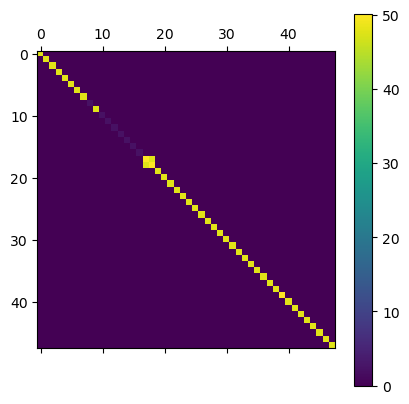

In [204]:
# Show the thermo covariance matrix
plt.matshow(uncertainty.thermo_covariance_matrix)
plt.colorbar()

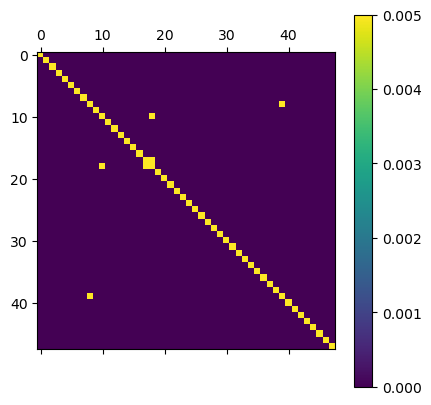

In [205]:
# Zoom in to see which parameters are correlated: the answer is not many -- onyl a handful of similar gorups
plt.matshow(uncertainty.thermo_covariance_matrix)
plt.colorbar()
plt.clim([0, 0.005])

# Now do kinetics covariance

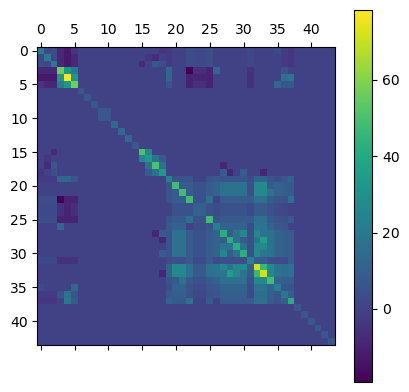

In [206]:
uncertainty.get_kinetic_covariance_matrix()
# Show the kinetics covariance matrix
plt.matshow(uncertainty.kinetic_covariance_matrix)
plt.colorbar()

In [207]:
delta_ln_k = np.sqrt(np.max(uncertainty.kinetic_covariance_matrix))  # that's 1 std dev ln k

# which corresponds to kmax/k of
np.exp(delta_ln_k * np.sqrt(3))

# 6.7 orders of magnitude. Okay. For the worst case scenario, yeah...
np.log10(np.exp(delta_ln_k * np.sqrt(3)))

6.655543823643739

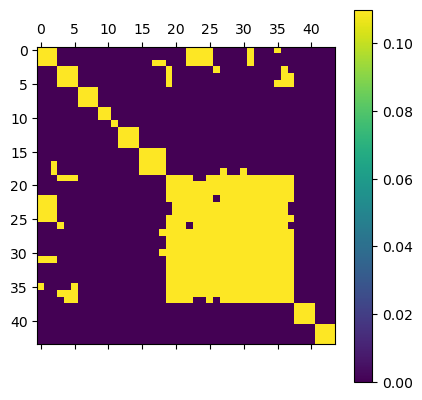

In [208]:
# zoom in to highlight correlations
plt.matshow(uncertainty.kinetic_covariance_matrix)
plt.colorbar()
plt.clim([0, 0.11])

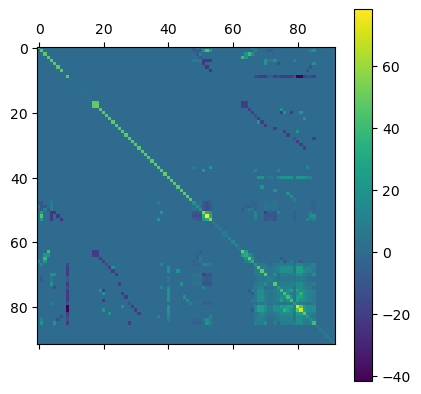

In [211]:
uncertainty.get_overall_covariance_matrix()
plt.matshow(uncertainty.overall_covariance_matrix)
plt.colorbar()

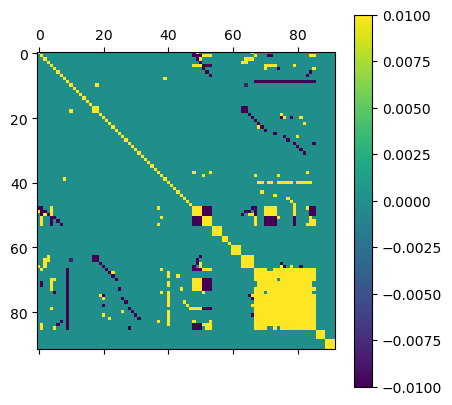

In [213]:
uncertainty.get_overall_covariance_matrix()
plt.matshow(uncertainty.overall_covariance_matrix)
plt.colorbar()
plt.clim([-0.01, 0.01])

In [214]:
np.save('thermo_cov.npy', uncertainty.thermo_covariance_matrix)
np.save('kinetic_cov.npy', uncertainty.kinetic_covariance_matrix)
np.save('overall_cov.npy', uncertainty.overall_covariance_matrix)

1.329398123272132

In [93]:
np.sqrt(uncertainty.kinetic_covariance_matrix[0,0])

3.7461227653855027

In [99]:
for i in range(len(reaction_list)):
    print(f'{i}\t{np.sqrt(uncertainty.kinetic_covariance_matrix[i, i])}\t{reaction_list[i]}')

0	3.7461227653855027	CH2X_1 + HOX_3 <=> CH3X_4 + OX_1
1	3.7461227653855027	CHX_1 + HOX_3 <=> CH2X_1 + OX_1
2	3.7461227653855027	CX_1 + HOX_3 <=> CHX_1 + OX_1
3	3.7461227653855027	OX_1 + HCOX_3 <=> HOX_3 + COX_5
4	3.7461227653855027	H2O* + OX_1 <=> HOX_3 + HOX_3
5	3.7461227653855027	CH4* + OX_1 <=> CH3X_4 + HOX_3
6	2.705601781489656	HCCH + X_3 + X_3 <=> HCCH_2X
7	2.705601781489656	H2CCH2 + X_3 + X_3 <=> H2CCH2_2X
8	2.705601781489656	H2CO + X_3 + X_3 <=> H2CO_2X
9	2.705601781489656	H2 + X_3 + X_3 <=> HX_3 + HX_3
10	2.705601781489656	H2 + X_3 + X_3 <=> HX_3 + HX_3
11	3.7461227653855027	NO + X_3 <=> NO_X
12	3.7461227653855027	H2O + X_3 <=> H2O*
13	3.7461227653855027	CO2 + X_3 <=> CO2X
14	2.705601781489656	CH4 + X_3 <=> CH4*
15	2.705601781489656	CC_2X <=> CX_1 + CX_1
16	2.705601781489656	CCH_2X <=> CX_1 + CHX_1
17	2.705601781489656	HCCH_2X <=> CHX_1 + CHX_1
18	2.705601781489656	HCCH2_2X <=> CHX_1 + CH2X_1
19	2.705601781489656	HOCXO_1 + X_3 <=> COX_5 + HOX_3
20	3.7461227653855027	NH2_X + X_3

In [105]:
uncertainty.thermo_covariance_matrix[0,0] * 4184 * 4184

837807930.687744

In [101]:
varH = np.float_power(28945.5, 2.0)

In [102]:
varH

837841970.25

In [141]:
type(uncertainty.reaction_list[10].kinetics)

rmgpy.kinetics.surface.StickingCoefficientBEP